**To do list**
* find tSNE/PCA/FA/CCA vector using all areas neural data
  * project neural dynamics into tSNE/Umap/MDS compenonts
  * project neural dynamics into PCA/FA compenonts
  * project neural dynamics into CCA compenonts
  * cluster across areas by PCA/FA/tSNE
* find useful weight_vector by training a decoder
  * various decoder, input:neural data & output:stimuli
    * get accuracy across time
    * d prime for information
  * linear regression decoder, input:stimuli & output:neural data
* study information across information flow
* train a RNN and compare it with real neural data (subspace, dynamics & information)
  * train a RNN for fitting neural data
    * input: neural data, output: neural data, eg. LFADS
    * input: stimuli pattern, output: stimuli feature
    * input: stimuli pattern, output: neural data
  * train a GNN for neural data across areas
* find a good visualization method to show change of dynamics pattern across time & areas

tips:
* from scipy.ndimage import gaussian_filter1d

In [8]:
import os
import torch
from torch import nn
from torch import optim
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import subspace_angles
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
functional_connectivity_type_sessions = sessions[sessions["session_type"] == "functional_connectivity"]
functional_connectivity_type_sessions.tail()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
835479236,2019-10-03T00:00:00Z,813701562,functional_connectivity,121.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,582,1857,5,"[LP, DG, CA1, VISmmp, nan, SCiw, SCig, SCop, S..."
839068429,2019-10-03T00:00:00Z,817060751,functional_connectivity,129.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,742,2298,6,"[APN, LP, MB, DG, CA1, VISam, nan, VISpm, ProS..."
839557629,2019-10-03T00:00:00Z,821469666,functional_connectivity,115.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,450,1853,5,"[APN, NOT, MB, DG, CA1, VISam, nan, VISpm, LGd..."
840012044,2019-10-03T00:00:00Z,820866121,functional_connectivity,116.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,758,2298,6,"[APN, DG, CA1, VISam, nan, LP, VISpm, VISp, LG..."
847657808,2019-10-03T00:00:00Z,827809884,functional_connectivity,126.0,F,wt/wt,874,2298,6,"[APN, NOT, DG, HPF, ProS, CA1, VISam, nan, MB,..."


In [3]:
session = cache.get_session_data(839068429)
session.metadata

{'specimen_name': 'Sst-IRES-Cre;Ai32-434488',
 'session_type': 'functional_connectivity',
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'sex': 'F',
 'age_in_days': 129.0,
 'rig_equipment_name': 'NP.2',
 'num_units': 742,
 'num_channels': 2298,
 'num_probes': 6,
 'num_stimulus_presentations': 77361,
 'session_start_time': datetime.datetime(2019, 3, 19, 12, 48, 5, tzinfo=tzoffset(None, -25200)),
 'ecephys_session_id': 839068429,
 'structure_acronyms': ['APN',
  'LP',
  'MB',
  'DG',
  'CA1',
  'VISam',
  nan,
  'VISpm',
  'ProS',
  'SUB',
  'VISp',
  'CA3',
  'VISl',
  'VIS',
  'LGd',
  'TH',
  'VISrl'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings_contrast',
  'natural_movie_one_more_repeats',
  'natural_movie_one_shuffled',
  'drifting_gratings_75_repeats',
  'dot_motion']}

In [34]:
areas = session.structure_acronyms
print(len(areas))
print(areas)
areas = ['LP', 'LGd', 'VISp', 'VISl', 'VISrl', 'VISpm', 'VISam']

whole_neurons = 0
for i, area in enumerate(areas):
    units = session.units[session.units["ecephys_structure_acronym"] == area].shape[0]
    whole_neurons = whole_neurons + units
    print(f'{area}: {units}')
print(f'whole_neurons: {whole_neurons}')

17
['APN', 'LP', 'MB', 'DG', 'CA1', 'VISam', nan, 'VISpm', 'ProS', 'SUB', 'VISp', 'CA3', 'VISl', 'VIS', 'LGd', 'TH', 'VISrl']
LP: 64
LGd: 9
VISp: 85
VISl: 47
VISrl: 44
VISpm: 60
VISam: 42
whole_neurons: 351


In [4]:
def spike_matrix(area, stim_table, bin=0.1, period=2):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, period + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def spike_matrix_blank(area, stim_table, bin=0.1, period=2, blank=0.5):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]  
    time_bins = np.arange(0-blank, period+bin+blank, bin)

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def spike_counts_bins(spikes_raster, bin_len):

    if bin_len == 1:
        return
    
    trials_num, trial_len, units_num = spikes_raster.shape
    binned_trial_len = int(trial_len / bin_len)

    if (trial_len % bin_len) != 0:
        spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

    spikes_raster = spikes_raster.transpose([0, 2, 1])
    spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
    spikes = spikes_raster.sum(2)
    spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
    spikes = spikes.transpose([0, 2, 1])

    return spikes

def spike_matrix_step(area, stim_table, bin=0.001, period=2, blank=0.5, window_len=0.1):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]  
    time_bins = np.arange(0-blank, period+bin+blank+window_len, bin)

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    spike_counts = spike_counts.values

    response_time = spike_counts.shape[1]-int(window_len/bin)
    response_matrix = np.zeros([spike_counts.shape[0], response_time, spike_counts.shape[2]])

    for t in np.arange(response_time):
        window = np.arange(t, t+int(window_len/bin))
        spike_counts_2 = spike_counts_bins(spike_counts[:, window, :], int(window_len/bin))
        response_matrix[:, t, :] = spike_counts_2[:, 0, :]

    return response_matrix

In [5]:
drift_stim_table = session.get_stimulus_table('drifting_gratings_75_repeats')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
40339,0.8,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3491.787689,5,drifting_gratings_75_repeats,3493.789399,2,2.00171,2082
40340,0.8,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3494.790211,5,drifting_gratings_75_repeats,3496.791851,2,2.00164,2082
40341,0.1,45,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3497.792659,5,drifting_gratings_75_repeats,3499.794299,2,2.00164,2083
40342,0.1,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3500.795181,5,drifting_gratings_75_repeats,3502.796841,2,2.00166,2084
40343,0.1,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3503.797659,5,drifting_gratings_75_repeats,3505.799319,2,2.00166,2084


In [6]:
drift_stim_table['stimulus_condition_id'].value_counts()

2089    75
2088    75
2087    75
2086    75
2085    75
2084    75
2083    75
2082    75
Name: stimulus_condition_id, dtype: int64

In [57]:
blank = 0.5
bin = 0.001
period_drift = 2
window_len = 0.1

areas = ['LP', 'LGd', 'VISp', 'VISl', 'VISrl', 'VISpm', 'VISam']
ori_list = [0.0, 45.0, 90.0, 135.0]
cont_list = [0.1, 0.8]

drift_stim_table = session.get_stimulus_table('drifting_gratings_75_repeats')
drift_response_matrix = {}          # areas*orientations*contrasts, repeats*bins*neurons

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

for i, area in enumerate(areas):
    drift_response_matrix[area] = {}
    for j, ori in enumerate(ori_list):
        drift_response_matrix[area][ori] = {}
        for k, cont in enumerate(cont_list):
            stim_table = drift_stim_table[(drift_stim_table['orientation'] == ori_list[j]) 
                                & (drift_stim_table['contrast'] == cont_list[k])]
            design_matrix = spike_matrix_step(area, stim_table, bin=bin, period=period_drift, blank=blank, window_len=window_len)
            drift_response_matrix[area][ori][cont] = design_matrix  

print(drift_response_matrix[area][ori][cont].shape)

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(6, 7), (10, 11), (17, 18), (18, 19), (30, 31), (32, 33), (34, 35), (35, 36), (36, 37), (54, 55), (58, 59), (70, 71), (71, 72)], with a maximum overlap of 0.09755747051440267 seconds.
  warnings.warn("You've specified some overlapping time intervals "
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(2, 3), (3, 4), (12, 13), (22, 23), (35, 36), (40, 41), (42, 43), (45, 46), (73, 74)], with a maximum overlap of 0.09754747051465529 seconds.
  warnings.warn("You've specified some overlapping time intervals "
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/pytho

(75, 3000, 42)


In [58]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

n_repeats = 75
train_test_ratio = 0.8      # using 80% data for train
n_train = int(train_test_ratio*n_repeats)
shuffle_index = torch.randperm(n_repeats)
train_index = shuffle_index[:n_train]
test_index = shuffle_index[n_train:]

_, n_bins, _ = drift_response_matrix['VISp'][45][0.8].shape
whole_drift_response_matrix = np.empty((len(ori_list), len(cont_list), n_repeats, n_bins, whole_neurons))  # using all neurons
whole_drift_ori_label = np.tile(np.arange(len(ori_list)), (len(cont_list), n_repeats)).reshape(len(cont_list), n_repeats, len(ori_list)).transpose([2, 0, 1])
print(whole_drift_response_matrix.shape)
print(whole_drift_ori_label.shape)

for i, ori in enumerate(ori_list):
    for j, cont in enumerate(cont_list):
        response_matrix = np.empty((n_repeats, n_bins, 0))
        for k, area in enumerate(areas):
            response_matrix = np.concatenate((response_matrix, drift_response_matrix[area][ori][cont]), axis = 2)

        whole_drift_response_matrix[i][j] = response_matrix

whole_drift_response_train = whole_drift_response_matrix[:, :, train_index, :, :]
whole_drift_response_test = whole_drift_response_matrix[:, :, test_index, :, :]
whole_drift_ori_label_train = whole_drift_ori_label[:, :, train_index]
whole_drift_ori_label_test = whole_drift_ori_label[:, :, test_index]

print(whole_drift_response_train.shape)
print(whole_drift_response_test.shape)
print(whole_drift_ori_label_train.shape)
print(whole_drift_ori_label_test.shape)

(4, 2, 75, 3000, 351)
(4, 2, 75)
(4, 2, 60, 3000, 351)
(4, 2, 15, 3000, 351)
(4, 2, 60)
(4, 2, 15)


In [102]:
class DeepNet(nn.Module):
  """Deep Network with one hidden layer, for classification

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer
    n_classes (int): number of outputs, i.e. number of classes to output
      probabilities for

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden, n_classes):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden)  # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, n_classes)  # hidden units --> outputs
    self.logprob = nn.LogSoftmax(dim=1)  # probabilities across columns should sum to 1 (each output row corresponds to a different input)

  def forward(self, r):
    """Predict stimulus orientation bin from neural responses

    Args:
      r (torch.Tensor): n_stimuli x n_inputs tensor with neural responses to n_stimuli

    Returns:
      torch.Tensor: n_stimuli x n_classes tensor with predicted class probabilities

    """
    h = torch.relu(self.in_layer(r))
    logp = self.logprob(self.out_layer(h))
    return logp

def train(net, loss_fn, train_data, train_labels, n_epochs=50, learning_rate=1e-4, test_data=None, test_labels=None, L2_penalty=0, L1_penalty=0):
  """Run gradient descent to opimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the stimuli corresponding to each row of train_data
    n_iter (int, optional): number of iterations of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent
    test_data (torch.Tensor, optional): n_test x n_neurons tensor with neural responses to test on
    test_labels (torch.Tensor, optional): n_test x 1 tensor with orientations of the stimuli corresponding to each row of test_data
    L2_penalty (float, optional): l2 penalty regularizer coefficient
    L1_penalty (float, optional): l1 penalty regularizer coefficient

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []
  test_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # evaluate loss function
    if L2_penalty==0 and L1_penalty==0:
      # normal loss function
      loss = loss_fn(out, train_labels)
    else:
      # custom loss function from bonus exercise 3.3
      loss = loss_fn(out, train_labels, net.in_layer.weight, L2_penalty, L1_penalty)

    # Clear previous gradients
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Get loss for test_data, if given (we will use this in the bonus exercise 3.2 and 3.3)
    if test_data is not None:
      out_test = net(test_data)
      # evaluate loss function
      if L2_penalty==0 and L1_penalty==0:
        # normal loss function
        loss_test = loss_fn(out_test, test_labels)
      else:
        # (BONUS code) custom loss function from Bonus exercise 3.3
        loss_test = loss_fn(out_test, test_labels, net.in_layer.weight,
                            L2_penalty, L1_penalty)
      test_loss.append(loss_test.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # # Track progress
    # if (i + 1) % (n_epochs // 5) == 0:
    #   if test_data is None:
    #     print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')
    #   else:
    #     print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f} | test_loss: {loss_test.item():.3f}')

  if test_data is None:
    return train_loss
  else:
    return train_loss, test_loss

In [100]:
def plot_decoded_accuracy(frac_correct, n_bins):

  start_time = (blank-window_len/2)/bin
  end_time = (period_drift+blank-window_len/2)/bin

  f, ax = plt.subplots(figsize=(10, 10))

  ax.plot(np.arange(n_bins), frac_correct)
  ax.set_title(f'decoded_accuracy across time, all neurons, both contrast')
  ax.set_xticks([0, start_time, start_time+500, start_time+1000, start_time+1500, end_time, 3000])
  ax.set_xticklabels([-500, 0, 500, 1000, 1500, 2000, 2500])
  ax.set_xlabel('ms')
  ax.set_ylabel('decoding accuracy')

  return

def plot_decoded_results(train_loss, test_loss, test_labels, predicted_test_labels, ori_list):
  """ Plot decoding results in the form of network training loss and test predictions

  Args:
    train_loss (list): training error over iterations
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    predicted_test_labels (torch.Tensor): n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network

  """

  # Plot results
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

  # Plot the training loss over iterations of GD
  ax1.plot(train_loss)
  # Plot the testing loss over iterations of GD
  ax1.plot(test_loss)
  ax1.legend(['train loss', 'test loss'])

  # Plot true stimulus orientation vs. predicted class
  ax2.plot(test_labels.squeeze(), predicted_test_labels, '.r')
  ax2.plot(np.arange(len(ori_list)), np.arange(len(ori_list)), 'b')

  ax1.set_xlim([0, None])
  ax1.set_ylim([0, None])
  ax1.set_xlabel('epochs of gradient descent')
  ax1.set_ylabel('negative log likelihood')
  ax2.set_xlabel('true stimulus orientation ($^o$)')
  ax2.set_ylabel('decoded orientation ($^o$)')

  ax2.set_xticks(np.arange(len(ori_list)))
  ax2.set_xticklabels(ori_list)
  ax2.set_yticks(np.arange(len(ori_list)))
  ax2.set_yticklabels(ori_list)

  # fig.suptitle('all neurons, both contrasts, all time bins', verticalalignment='bottom', fontsize=16) 

  plt.tight_layout()

def decode_orientation(net, n_classes, loss_fn, train_data, train_labels, test_data, test_labels, n_epochs=200, L2_penalty=0, L1_penalty=0):
  """ Initialize, train, and test deep network to decode binned orientation from neural responses

  Args:
    net (nn.Module): deep network to run
    n_classes (scalar): number of classes in which to bin orientation
    loss_fn (function): loss function to run
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    test_data (torch.Tensor): n_test x n_neurons tensor with neural
      responses to train on
    test_labels (torch.Tensor): n_test x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians
    n_iter (int, optional): number of iterations to run optimization
    L2_penalty (float, optional): l2 penalty regularizer coefficient
    L1_penalty (float, optional): l1 penalty regularizer coefficient

  Returns:
    (list, torch.Tensor): training loss over iterations, n_test x 1 tensor with predicted orientations of the
      stimuli from decoding neural network
  """

  # Run GD on training set data, using learning rate of 0.1
  train_loss, test_loss = train(net, loss_fn, train_data, train_labels, learning_rate=0.1, test_data=test_data, test_labels=test_labels, 
                                n_epochs=n_epochs, L2_penalty=L2_penalty, L1_penalty=L1_penalty)

  # Decode neural responses in testing set data
  out = net(test_data)
  out_labels = np.argmax(out.detach(), axis=1)  # predicted classes

  frac_correct = (out_labels==test_labels).sum() / len(test_labels)
  # print(f'>>> fraction correct = {frac_correct:.3f}')

  return train_loss, test_loss, out_labels, frac_correct

In [103]:
response_train = whole_drift_response_train.reshape(len(ori_list)*len(cont_list)*whole_drift_response_train.shape[2], n_bins, whole_neurons)
response_test = whole_drift_response_test.reshape(len(ori_list)*len(cont_list)*whole_drift_response_test.shape[2], n_bins, whole_neurons)
label_train = whole_drift_ori_label_train.reshape(len(ori_list)*len(cont_list)*whole_drift_response_train.shape[2])
label_test = whole_drift_ori_label_test.reshape(len(ori_list)*len(cont_list)*whole_drift_response_test.shape[2])
print(response_train.shape)
print(response_test.shape)
print(label_train.shape)
print(label_test.shape)

response_train = torch.from_numpy(np.float32(response_train))
response_test = torch.from_numpy(np.float32(response_test))
label_train = torch.from_numpy((label_train))
label_test = torch.from_numpy(label_test)

(480, 3000, 351)
(120, 3000, 351)
(480,)
(120,)


* all neurons, both contrasts, all time bins

iteration 40/200 | loss: 0.104 | test_loss: 0.094
iteration 80/200 | loss: 0.028 | test_loss: 0.026
iteration 120/200 | loss: 0.015 | test_loss: 0.014
iteration 160/200 | loss: 0.010 | test_loss: 0.009
iteration 200/200 | loss: 0.007 | test_loss: 0.007
>>> fraction correct = 1.000


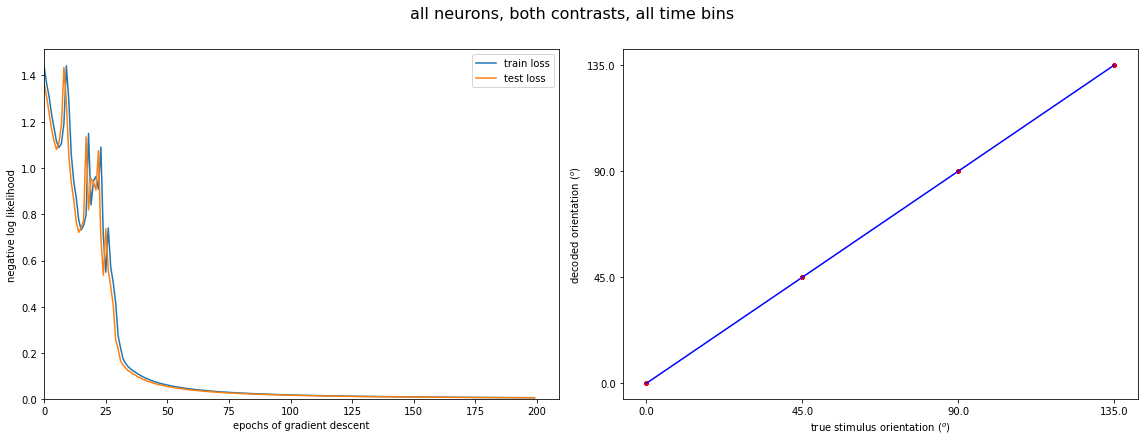

In [99]:
n_hidden_units = 20
n_classes = len(ori_list)

# Initialize network
net = DeepNet(whole_neurons, n_hidden_units, n_classes)  # use M=20 hidden units

# Initialize built-in PyTorch negative log likelihood loss function
loss_fn = nn.NLLLoss()

# Train network and run it on test images
# this function uses the train function you wrote before
train_loss, test_loss, predicted_test_labels, frac_correct = decode_orientation(net, n_classes, loss_fn, response_train.mean(1), label_train, response_test.mean(1), label_test)

# Plot results
plot_decoded_results(train_loss, test_loss, label_test, predicted_test_labels, ori_list)

* all neurons, both contrasts, across time bins

time 1/3000 ms | frac_correct: 0.18333333730697632
time 501/3000 ms | frac_correct: 0.9583333134651184
time 1001/3000 ms | frac_correct: 0.9833333492279053
time 1501/3000 ms | frac_correct: 0.9833333492279053
time 2001/3000 ms | frac_correct: 0.9916666746139526
time 2501/3000 ms | frac_correct: 0.9916666746139526


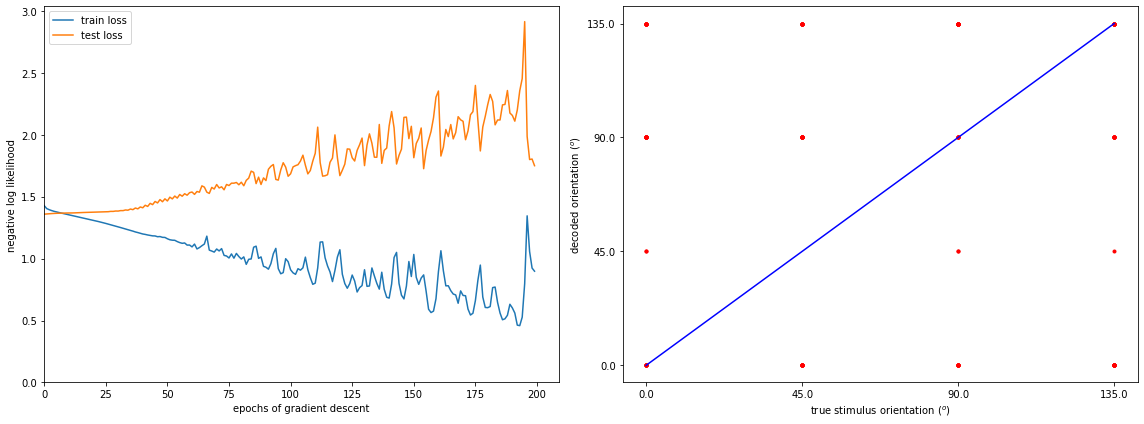

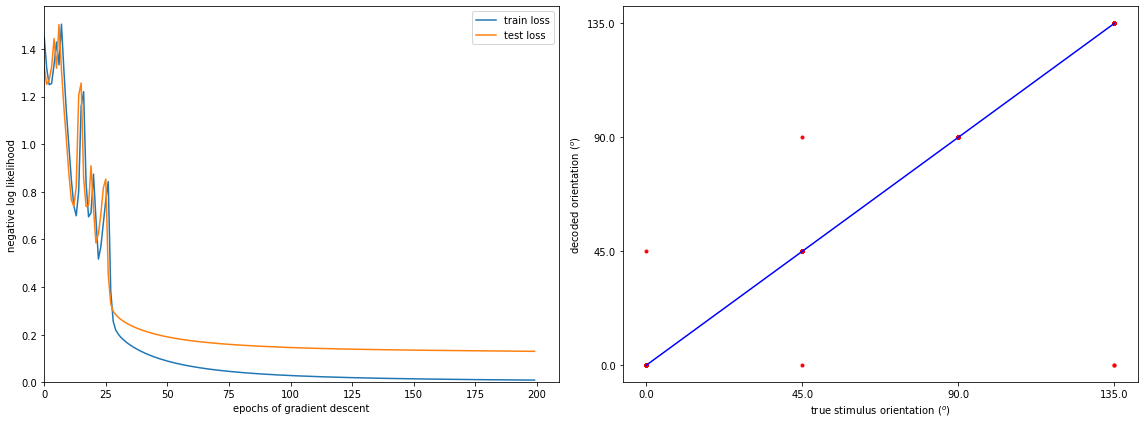

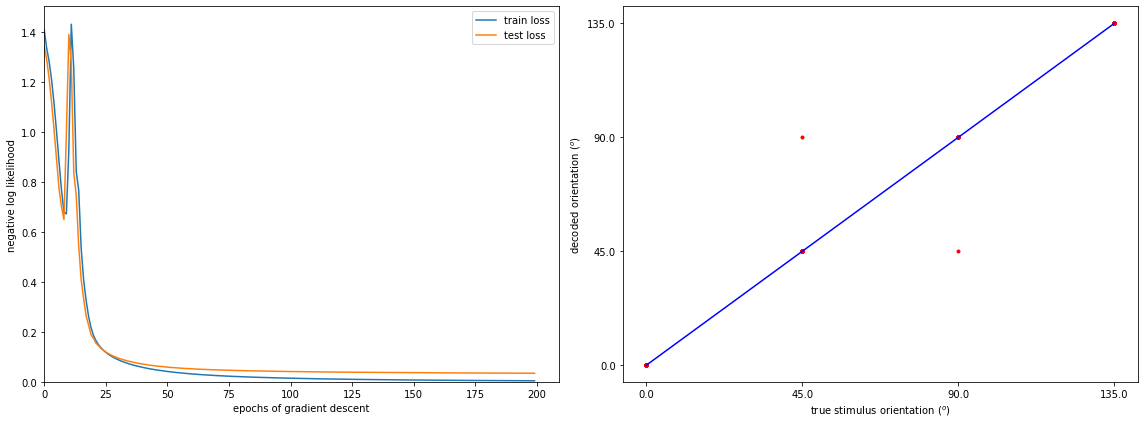

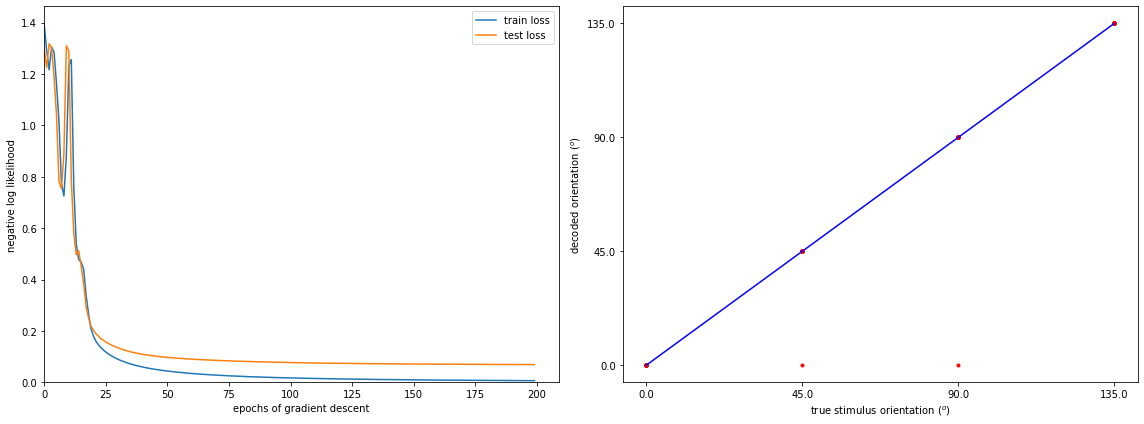

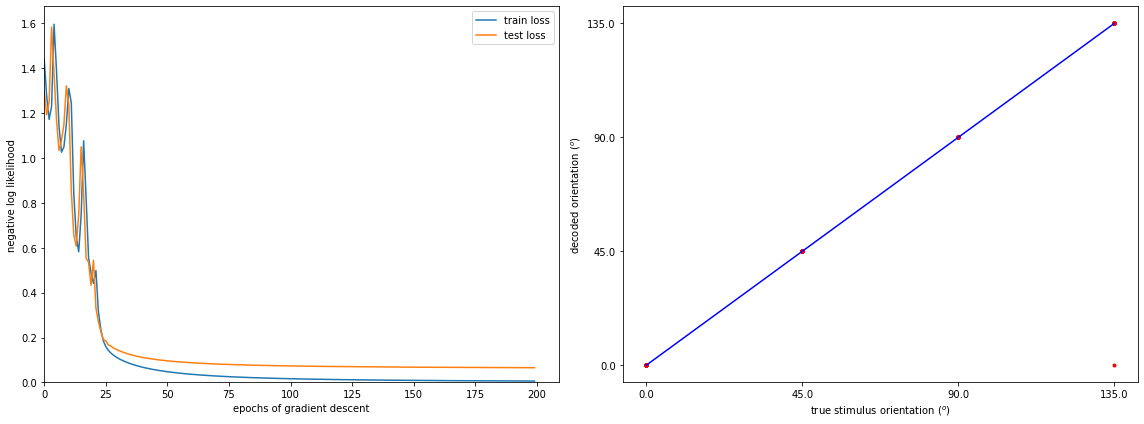

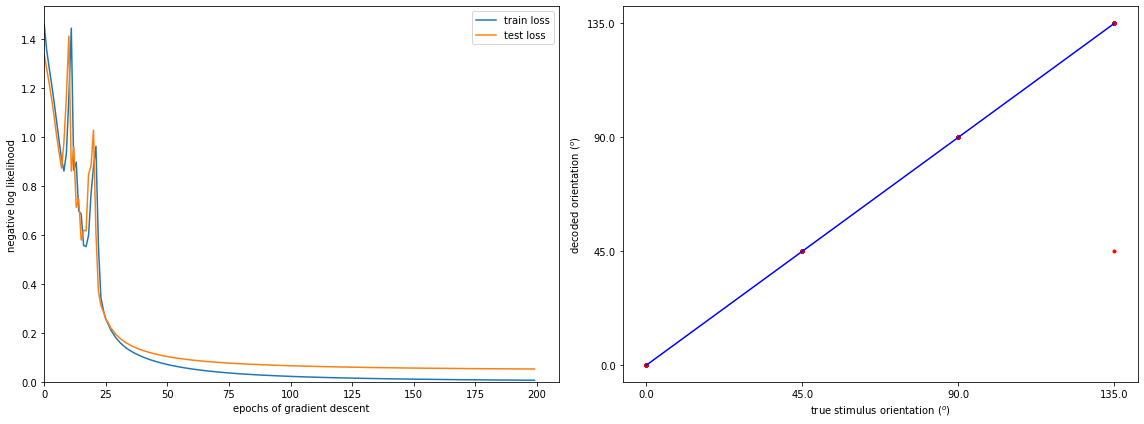

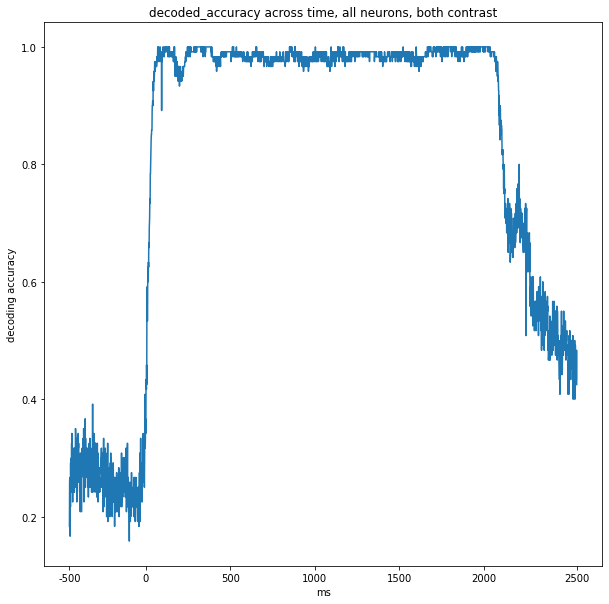

In [106]:
n_hidden_units = 20
n_classes = len(ori_list)
frac_correct = np.zeros(n_bins)

for i in np.arange(n_bins):

    # Initialize network
    net = DeepNet(whole_neurons, n_hidden_units, n_classes)  # use M=20 hidden units

    # Initialize built-in PyTorch negative log likelihood loss function
    loss_fn = nn.NLLLoss()

    # Train network and run it on test images
    # this function uses the train function you wrote before
    train_loss, test_loss, predicted_test_labels, frac_correct[i] = decode_orientation(net, n_classes, loss_fn, response_train[:, i, :], label_train, response_test[:, i, :], label_test)

    # Track progress
    if (i + 1) % (n_bins // 6) == 1:
        print(f'time {i + 1}/{n_bins} ms | frac_correct: {frac_correct[i]}')
        plot_decoded_results(train_loss, test_loss, label_test, predicted_test_labels, ori_list)

# Plot results
plot_decoded_accuracy(frac_correct, n_bins)